## **Learning curve & Complexity curve**

Complexity and learning curve analyses are some of the most important tasks in a Machine Learning project.

**Learning curve:** Graphs that compares the performance of a model on training and testing data over a varying number of training instances. We should generally see performance improve as the number of training points increases.

**Complexity curve:** Graphs that show the model performance over training and validation set for varying degree of model complexity (e.g. degree of polynomial for linear regression, number of layers or neurons for neural networks, number of estimator trees for a Boosting algorithm or Random Forest). Complexity curve allows us to verify when a model has learned as much as it can about the data without fitting to the noise. 

* The key is to find the spot that minimizes bias and variance by finding the right level of model complexity. Of course with more data any model can improve, and different models may be optimal.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_style("white")

In [8]:
df=pd.read_csv("data/loan_data.csv")
df_final = pd.get_dummies(df,['purpose'],drop_first=True)
df_final = df_final.drop('credit.policy',axis=1)

In [9]:
X=df_final.drop('not.fully.paid',axis=1)
y=df['not.fully.paid']

In [11]:
#divide the set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50)

print("Shape of validation set:", X_val.shape)
print("Shape of test set:", X_test.shape)
print("Shape of training set:", X_train.shape)

Shape of validation set: (1437, 17)
Shape of test set: (1437, 17)
Shape of training set: (6704, 17)


## **Decision Tree model**

In [13]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=5)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [14]:
predictions = dtree.predict(X_val)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

score1=accuracy_score(y_val,predictions)
print(score1)

0.81419624217119


## **Varying hyperparameters: Pruning the tree**

**Varying max_depth**

Looking **max_depth** (max depth of a tree) we see an increase in the validation set accuracy, accompanied by a decrease in training set accuracy for smaller trees. This means that for this dataset, a deeper tree clearly overfits the data and a shallow tree of depth 2/3 should be considered.

In [16]:

val_acc_max_depth=[]
val_f1_max_depth=[]
train_acc_max_depth=[]
train_f1_max_depth=[]
for i in range(3,21):
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=i,min_samples_leaf=1)
    dtree.fit(X_train,y_train)
    pred_train = dtree.predict(X_train)
    pred_val = dtree.predict(X_val)
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    train_acc_max_depth.append(acc_train)
    train_f1_max_depth.append(f1_train)
    val_acc_max_depth.append(acc_val)
    val_f1_max_depth.append(f1_val)

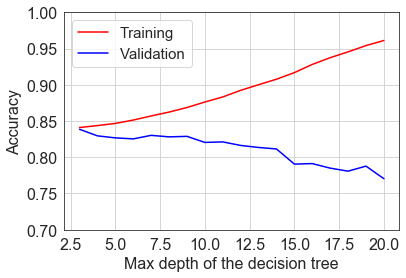

In [17]:

plt.plot(range(3,21),train_acc_max_depth,c='red')
plt.plot(range(3,21),val_acc_max_depth,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Max depth of the decision tree", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.7,1.0)
plt.show()

**min_samples_leaf with max_depth = 20**

With **min_samples_leaf** parameter we limit overfitting. If we allow a single leaf per node then the algorithm will fit to the noise of the data down to a single data point (splitting data on as low as two points) thereby making the decision boundary extremely nonlinear and vulnarable to the nosie.

In [19]:

val_acc_min_samples_leaf=[]
val_f1_min_samples_leaf=[]
train_acc_min_samples_leaf=[]
train_f1_min_samples_leaf=[]
for i in range(1,41):
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=i)
    dtree.fit(X_train,y_train)
    pred_train = dtree.predict(X_train)
    pred_val = dtree.predict(X_val)
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    train_acc_min_samples_leaf.append(acc_train)
    train_f1_min_samples_leaf.append(f1_train)
    val_acc_min_samples_leaf.append(acc_val)
    val_f1_min_samples_leaf.append(f1_val)

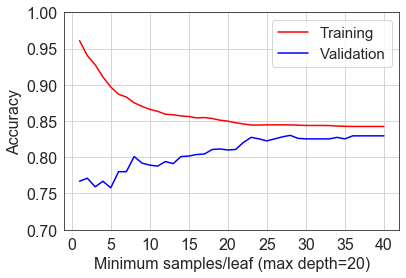

In [21]:

plt.plot(range(1,41),train_acc_min_samples_leaf,c='red')
plt.plot(range(1,41),val_acc_min_samples_leaf,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Minimum samples/leaf (max depth=20)", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.7,1.0)
plt.show()

## **LEARNING CURVE/Varying training set size** 

We run a loop over a range of fractions (10% to 100%) and sample random points up to that fraction from the original data set.

The plot shows that for this dataset and a sensible choice of hyperparameters, **the accuracy is not a strong function of training data size down to small fraction of the original data**. This means, in principle, we can run the algorithm on a much smaller model than using all the data and still create decent predictions.

In [22]:

val_acc_train_size=[]
val_f1_train_size=[]
train_acc_train_size=[]
train_f1_train_size=[]
val_range=(10,101,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    # Fitting
    percentage=i*0.01
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=20)
    # Sampling
    df_sampled = df_final.sample(frac=percentage)
    X_train_sampled=df_sampled.drop('not.fully.paid',axis=1)
    y_train_sampled=df_sampled['not.fully.paid']
    # Fitting and Predictions
    dtree.fit(X_train_sampled,y_train_sampled)
    pred_train = dtree.predict(X_train_sampled)
    pred_val = dtree.predict(X_val)
    # Accuracy and F1 score
    acc_train=accuracy_score(y_train_sampled,pred_train)
    f1_train = f1_score(y_train_sampled,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    # Appending to the lists
    train_acc_train_size.append(acc_train)
    train_f1_train_size.append(f1_train)
    val_acc_train_size.append(acc_val)
    val_f1_train_size.append(f1_val)
    if i%10==0:
        print(f"Done for: {i}% training set size")

Done for: 10% training set size
Done for: 20% training set size
Done for: 30% training set size
Done for: 40% training set size
Done for: 50% training set size
Done for: 60% training set size
Done for: 70% training set size
Done for: 80% training set size
Done for: 90% training set size
Done for: 100% training set size


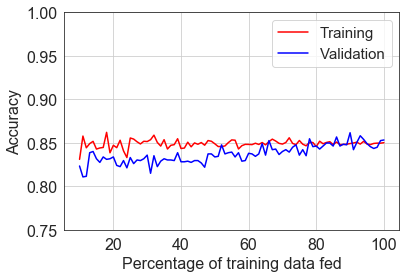

In [23]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_train_size,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_train_size,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Percentage of training data fed", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.75,1.0)
plt.show()

## **Neural Networks (Multi-layer perceptron)**